# Baseline characteristics

In [1]:
import pandas as pd

# load csv of practices contacted 
nim = pd.read_csv('nimodipine_practices.csv')
nim = nim.rename(columns={"practice_":"practice"}).drop("Unnamed: 0", axis=1)
nim.head()

,practice,12-mo_items,12-mo_quantity,12-mo_total_list_size,3-mo_items,3-mo_quantity,3-mo_total_list_size,3-mo quantity per 1000
0,A82036,9,482,10131.333333,1,34,10188.000000,3.337260
1,A83047,11,2364,14769.875000,3,672,14810.000000,45.374747
2,B82005,1,100,58595.000000,1,100,58595.000000,1.706630
3,B82013,1,90,20084.000000,1,90,20084.000000,4.481179
4,B86081,13,1092,14327.916667,4,336,14406.333333,23.323075


In [2]:
GBQ_PROJECT_ID = '620265099307'

q = '''
SELECT 
prac.code AS practice_id, 
prac.name,
ccg_id, 
total_list_size, 
CASE WHEN total_list_size < 3000 THEN 1 ELSE 0 END AS small_flag,
CASE WHEN gp_count =1 THEN 1 ELSE 0 END AS single_handed,
gp_count,
DATE_DIFF('2019-05-01', CAST (open_date AS DATE), YEAR) as open_years,
CASE WHEN d.dispensing_patients > 0 THEN 1 ELSE 0 END as dispensing,
--ru.rural_urban_code,
CASE WHEN ru.rural_urban_code IN (1,2) THEN 1 ELSE 0 END as rural,
CASE WHEN ru.rural_urban_code IN (5,6) THEN 1 ELSE 0 END as urban,
CAST(imd.value AS FLOAT64) AS imd
    
from ebmdatalab.hscic.practices prac
INNER JOIN ebmdatalab.hscic.practice_statistics stat ON prac.code = stat.practice AND DATE(stat.month) = '2019-03-01'   -- latest month
LEFT JOIN ebmdatalab.bsa.dispensing_practices_feb_2018 d ON prac.code= d.practice_code
LEFT JOIN `ONS.practices_rural_urban` ru ON prac.code = ru.code
LEFT JOIN (SELECT area_code, value FROM `ebmdatalab.alex.indicators_GP_data` 
    where indicator_name = "Deprivation score (IMD 2015)" and Area_Type = "GP") imd ON prac.code = imd.area_code

WHERE 
prac.ccg_id NOT IN ('99P')  -- exclude any CCGs involved in preliminary testing
AND prac.code NOT IN ('')       -- exclude any practices involved in preliminary testing -- replace with [list of practices to exclude]
AND prac.setting = 4            -- include standard practices only
AND prac.status_code = 'A'      -- active status (exclude dormant and closed)

ORDER BY practice_id
'''

stats = pd.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)
stats.head()

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,practice_id,name,ccg_id,total_list_size,small_flag,single_handed,gp_count,open_years,dispensing,rural,urban,imd
0,A81001,THE DENSHAM SURGERY,00K,4095,0,0,2.0,45,0,0,0,29.140310
1,A81002,QUEENS PARK MEDICAL CENTRE,00K,19547,0,0,13.0,45,0,0,0,29.689706
2,A81004,BLUEBELL MEDICAL CENTRE,00M,10737,0,0,5.0,45,0,0,0,34.411828
3,A81005,SPRINGWOOD SURGERY,00M,8069,0,0,6.0,45,0,0,0,15.743812
4,A81006,TENNANT STREET MEDICAL PRACTICE,00K,14632,0,0,10.0,45,0,0,0,31.791515


## Compare practice characteristics to rest of country

In [3]:
s2 = stats.merge(nim, right_on="practice", left_on="practice_id", how="left")
s2["intervention_flag"] = 0
s2.loc[pd.notnull(s2["practice"]), "intervention_flag"] = 1

s2.groupby("intervention_flag").agg({"practice_id":"nunique", 
         "total_list_size": "mean",
         "small_flag": "mean",
         "single_handed":"mean",
         "gp_count":"mean",
         "dispensing":"mean",  
         "imd":"mean"})


,practice_id,total_list_size,small_flag,single_handed,gp_count,dispensing,imd
intervention_flag,,,,,,,
0,6825,8595.806154,0.085568,0.066374,5.997361,0.141685,23.496131
1,58,12051.155172,0.034483,0.017241,7.741379,0.137931,22.777960


# Prescribing outcomes
### 1. Change from baseline in the rate of nimodipine prescribing per 1,000 registered patients compared to the change in an earlier control period. 

**Follow-up period**: Three months following intervention, not including month of sending.

**Baseline period:** latest available three months of data at start of study.

**Control period:** baseline period minus one year, follow-up period minus one year. 


### Set dates

In [4]:
###  update dates d7 and d6 to 2019 as appropriate
# (dates 1-5 are used for the "control" period one year prior to actual baseline and follow-up)
import datetime

intervention = "2019-01-01" # update to month interventions sent
d7 = '2018-11-01' # month after end of follow-up period (NB use 2018 for testing; update to 2019 for analysis)
d6 = '2018-08-01' # start of 3-month follow-up period (NB use 2018 for testing; update to 2019 for analysis)

d5 = '2018-11-01' # month after end of "follow-up" period (one year prior to actual follow-up) 
d4 = '2018-08-01' # start of 3-month "follow-up" period (one year prior to actual follow-up)

d3 = '2018-05-01' # month after end of "baseline" period
d2 = '2018-02-01' # start of 3-month "baseline" period
d1 = '2017-05-01' # start of 12-month "baseline" period

### Import nimodipine prescribing data

In [5]:
#  

# import data for all practices prescribing nimodipine, 
# excluding those which are dormant/closed,
# excluding practices which are not standard general practices
# excluding practices in Devon CCG (or one of its predecessor organisations NEW Devon CCG)

# Import dataset from BigQuery
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q = '''
WITH a AS ( -- all nimodipine data 
SELECT * FROM 
`ebmdatalab.hscic.normalised_prescribing_standard` 
WHERE SUBSTR(bnf_code,1,9) = '0206020M0'
AND EXTRACT(year FROM month) > 2016)

SELECT  
    a.practice,
    a.pct,
    setting,
    a.month,
    total_list_size,
    SUM(a.items) AS items,
    SUM(a.quantity) AS quantity
FROM a
   INNER JOIN hscic.practices b ON a.practice = b.code AND setting=4 
   INNER JOIN `hscic.practice_statistics_all_years` pop  ON a.practice = pop.practice AND a.month = pop.month and status_code = "A"
WHERE pct NOT IN ('99P','15N')
    AND pop.total_list_size > 1000 
    AND (male_25_34 + male_35_44 + male_45_54 + male_55_64 + female_25_34 + female_35_44 + female_45_54 + female_55_64)
    / total_list_size BETWEEN 0.1 and 0.85
GROUP BY practice, pct, setting, month, total_list_size
'''
df1 = pd.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)

        ## note: parsing dates is quite memory-intensive, make sure not too many programmes running

df1["month"] = pd.to_datetime(df1.month)

df1.head() # this gives the first few rows of data

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,practice,pct,setting,month,total_list_size,items,quantity
0,A89018,00P,4,2017-08-01 00:00:00+00:00,4730,4,112
1,H81035,09N,4,2018-12-01 00:00:00+00:00,10744,1,60
2,E84684,07P,4,2018-08-01 00:00:00+00:00,3690,1,28
3,P81655,00X,4,2017-09-01 00:00:00+00:00,3371,1,56
4,P81655,00X,4,2018-01-01 00:00:00+00:00,8193,1,56


In [6]:
# classify dates as part of follow-up period 

df1["follow-up"] = False
df1.loc[(df1['month']>=d6)&(df1['month']<d7), "follow-up"] = True

fu = df1.loc[df1["follow-up"]==True].groupby(["practice"])["quantity","total_list_size"].agg({"quantity":"sum","total_list_size":"mean"}).reset_index()

fu.head()

,practice,quantity,total_list_size
0,A82029,200,3495.5
1,A82036,224,10136.5
2,A83029,100,4928.0
3,A83047,448,14758.0
4,A84011,600,7533.0


### Merge baseline and follow-up data

In [7]:

nim2 = nim[["practice","3-mo_quantity","3-mo_total_list_size"]].merge(fu, on="practice",how="left")
nim2["baseline_rate"] = 1000*nim2["3-mo_quantity"]/nim2["3-mo_total_list_size"]
nim2["follow-up_rate"] = 1000*nim2["quantity"]/nim2["total_list_size"]
nim2 = nim2.fillna(0)
nim2.head()

,practice,3-mo_quantity,3-mo_total_list_size,quantity,total_list_size,baseline_rate,follow-up_rate
0,A82036,34,10188.000000,224.0,10136.500000,3.337260,22.098357
1,A83047,672,14810.000000,448.0,14758.000000,45.374747,30.356417
2,B82005,100,58595.000000,0.0,0.000000,1.706630,0.000000
3,B82013,90,20084.000000,0.0,0.000000,4.481179,0.000000
4,B86081,336,14406.333333,252.0,14280.333333,23.323075,17.646647


### Statistical test (t-test)

In [8]:
nim3 = nim2.copy()

nim3 = nim3.drop("practice",axis=1).mean()

print(nim3)

from scipy import stats

print(stats.ttest_rel(nim2["baseline_rate"],nim2["follow-up_rate"]))


3-mo_quantity             251.310345
3-mo_total_list_size    12047.968391
quantity                  149.586207
total_list_size          5801.063218
baseline_rate              29.628092
follow-up_rate             16.507769
dtype: float64
Ttest_relResult(statistic=2.9148279882325068, pvalue=0.0050784486914953559)


### Compare to a previous "control" period for comparison

### identify control practices based on 12-month and 3-month prescribing data

In [9]:
### classify data by baseline and follow-up period

df2 = df1.copy()

df2["follow-up"] = False
df2["12-mo-baseline"] = False
df2["3-mo-baseline"] = False
df2.loc[(df2['month']>=d1)&(df2['month']<d3), "12-mo-baseline"] = True
df2.loc[(df2['month']>=d2)&(df2['month']<d3), "3-mo-baseline"] = True
df2.loc[(df2['month']>=d4)&(df2['month']<d5), "follow-up"] = True

df2.head()

,practice,pct,setting,month,total_list_size,items,quantity,follow-up,12-mo-baseline,3-mo-baseline
0,A89018,00P,4,2017-08-01 00:00:00+00:00,4730,4,112,False,True,False
1,H81035,09N,4,2018-12-01 00:00:00+00:00,10744,1,60,False,False,False
2,E84684,07P,4,2018-08-01 00:00:00+00:00,3690,1,28,True,False,False
3,P81655,00X,4,2017-09-01 00:00:00+00:00,3371,1,56,False,True,False
4,P81655,00X,4,2018-01-01 00:00:00+00:00,8193,1,56,False,True,False


In [10]:

# any prescribing in last 3 months
filter1 = df2.loc[df2["3-mo-baseline"]==True].groupby(["practice"])["items","quantity","total_list_size"].agg({"items":"sum","quantity":"sum","total_list_size":"mean"}).reset_index()
filter1 = filter1.rename(columns={"items":"3-mo_items","quantity":"3-mo_quantity", "total_list_size":"3-mo_total_list_size"})

#sum over 12 months
agg = df2.loc[df2["12-mo-baseline"]==True].groupby(["practice"])["items","quantity","total_list_size"].agg({"items":"sum","quantity":"sum","total_list_size":"mean"}).reset_index()

agg = agg.merge(filter1, on="practice", how="inner")#.groupby(["practice","3-mo-baseline"]).sum()
agg = agg.rename(columns={"items":"12-mo_items","quantity":"12-mo_quantity", "total_list_size":"12-mo_total_list_size"})

# More than one item of nimodipine prescribed OR more than 56 tablets prescribed in the latest 12 months#
agg = agg.loc[(agg["12-mo_items"]>1) | (agg["12-mo_quantity"]>56)]#.sort_values(by="quantity")
agg.head()

,practice,12-mo_items,12-mo_quantity,12-mo_total_list_size,3-mo_items,3-mo_quantity,3-mo_total_list_size
0,A81009,1,200,8740.000000,1,200,8740.0
1,A82029,7,700,3491.000000,2,200,3486.0
2,A82036,12,672,10017.818182,3,168,10033.0
3,A82045,12,632,8623.272727,2,72,8659.5
4,A82654,7,784,7606.571429,2,224,7616.5


In [11]:
# follow-up data for comparison group ("control")

con = agg[["practice","3-mo_quantity","3-mo_total_list_size"]].copy()
con["baseline_rate"] = 1000*con["3-mo_quantity"]/con["3-mo_total_list_size"]

con_fu = df1.loc[df1["follow-up"]==True].groupby(["practice"])["quantity","total_list_size"].agg({"quantity":"sum","total_list_size":"mean"}).reset_index()


con = con.merge(con_fu, on="practice",how="left")

# fill missing population figures with the earlier population, and fill blank quantities with zero
con["total_list_size"] = con["total_list_size"].fillna(con["3-mo_total_list_size"])
con = con.fillna(0)
con["follow-up_rate"] = 1000*con["quantity"]/con["total_list_size"]
con.head()

,practice,3-mo_quantity,3-mo_total_list_size,baseline_rate,quantity,total_list_size,follow-up_rate
0,A81009,200,8740.0,22.883295,0.0,8740.0,0.000000
1,A82029,200,3486.0,57.372347,200.0,3495.5,57.216421
2,A82036,168,10033.0,16.744742,224.0,10136.5,22.098357
3,A82045,72,8659.5,8.314568,0.0,8659.5,0.000000
4,A82654,224,7616.5,29.409834,0.0,7616.5,0.000000


In [12]:
con2 = con.copy()

con2 = pd.DataFrame(con2.drop("practice",axis=1).sum()).transpose()

con2["follow-up_rate"] = 1000*con2["quantity"]/con2["total_list_size"]

con2

,3-mo_quantity,3-mo_total_list_size,baseline_rate,quantity,total_list_size,follow-up_rate
0,16836.0,873410.666667,1980.693131,13727.0,921612.5,14.894546


### Statistical test for comparison group

In [13]:
con2 = con.copy()

con2 = con2.drop("practice",axis=1).mean()

#con2["follow-up_rate"] = 1000*con2["quantity"]/con2["total_list_size"]

print(con2)

from scipy import stats

print(stats.ttest_rel(con["baseline_rate"],con["follow-up_rate"]))



3-mo_quantity             215.846154
3-mo_total_list_size    11197.572650
baseline_rate              25.393502
quantity                  175.987179
total_list_size         11815.544872
follow-up_rate             20.235573
dtype: float64
Ttest_relResult(statistic=2.3978596517615385, pvalue=0.018913374453545902)


# 2. Change from baseline in overall rate of nimodipine prescribing per 1,000 population, across all practices in England.
For our secondary prescribing outcome we will assess the national change in rate of nimodipine prescribing across all practices using interrupted time series analysis. 

We exclude the same CCGs as per selection critieria

In [14]:
GBQ_PROJECT_ID = '620265099307'

q = '''SELECT  
    a.month,
    SUM(total_list_size) as total_list_size,
    SUM(a.items) AS items,
    SUM(a.quantity) AS quantity
FROM helen.nimodipine_20190513 a
   INNER JOIN hscic.practices b ON a.practice = b.code AND setting=4 
   INNER JOIN `hscic.practice_statistics_all_years` pop  ON a.practice = pop.practice AND a.month = pop.month
WHERE pct NOT IN ('99P','15N')
GROUP BY month
'''
df4 = pd.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)

        ## note: parsing dates is quite memory-intensive, make sure not too many programmes running

df4["month"] = pd.to_datetime(df4.month)

df4.head() # this gives the first few rows of data

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,month,total_list_size,items,quantity
0,2019-02-01 00:00:00+00:00,439546,53,4912
1,2017-04-01 00:00:00+00:00,524828,83,7847
2,2017-02-01 00:00:00+00:00,512018,69,7662
3,2018-04-01 00:00:00+00:00,526905,73,6006
4,2018-05-01 00:00:00+00:00,507893,81,6295


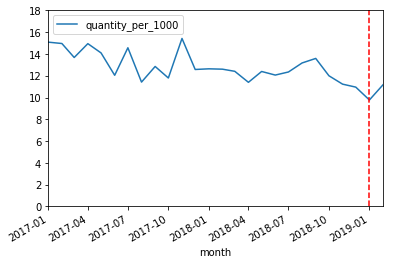

In [15]:
import matplotlib.pyplot as plt

df5 = df4.copy()
df5["quantity_per_1000"] = 1000*df5["quantity"]/df5["total_list_size"]

df5.plot("month","quantity_per_1000")

# mark intervention point
plt.axvline(x=intervention, color='r', ls='--')

plt.ylim((0,18))

plt.show()

### export data for ITSA analysis in STATA

In [16]:
df5.to_csv("nimodipine_national_for_itsa.csv")

# ENGAGEMENT OUTCOMES

## 1. Primary: Change from baseline in the proportion of practices having their dashboard viewed during the 5 week follow-up period. 

**Analytics data extraction procedure:**

Analytics - Behaviour - Site Content - All Pages

ADVANCED SEARCH: Page matching regexp "/practice" AND Exclude page including "/analyse", "/price_per_unit" and "/measure"
 DATE RANGE: Follow-up period: 5 weeks following the intervention, including date sent
Baseline period: 5 weeks prior to intervention.

 SHOW ROWS: 5000
Export as CSV Before importing, tidy up the csv to create a flat table (remove top and bottom groups of rows, convert numerical data to general format to remove commas)


### import pageviews data

In [17]:
import pandas as pd
# load practice-level pageviews data:

# post-intervention:
dfpa = pd.read_csv('pageviews_20190426-20190530.csv',usecols={"Page","Pageviews","Unique Pageviews"} )
dfpa["time_period"] = "after"

dfpb = pd.read_csv('pageviews_20190322-20190425.csv',usecols={"Page","Pageviews","Unique Pageviews"} )
dfpb["time_period"] = "before"

dfp = pd.concat([dfpa, dfpb])

dfp.head()

,Page,Pageviews,Unique Pageviews,time_period
0,/feedback/?from_url=https://openprescribing.ne...,9.0,9.0,after
1,/feedback/?from_url=https://openprescribing.ne...,3.0,1.0,after
2,/feedback/?from_url=https://openprescribing.ne...,1.0,1.0,after
3,/feedback/?from_url=https://openprescribing.ne...,2.0,1.0,after
4,/feedback/?from_url=https://openprescribing.ne...,2.0,1.0,after


### Find org ids from path, and limit to dashboard pages only

In [18]:
import numpy as np

dfp2 = dfp.copy()

#limit to dashboard pages only
dfp2 = dfp2.loc[dfp2.Page.str.len()==17]

# extract ccg/practice code from path
dfp2["org_id"] = np.where(dfp2.Page.str.contains("ccg"),dfp2.Page.str.replace('/ccg/', '').str[:3],dfp2.Page.str.replace('/practice/', '').str[:6])

dfp2.head()

,Page,Pageviews,Unique Pageviews,time_period,org_id
9,/practice/&00352/,1.0,1.0,after,&00352
12,/practice/08E998/,1.0,1.0,after,08E998
23,/practice/A81001/,1.0,1.0,after,A81001
25,/practice/A81002/,1.0,1.0,after,A81002
26,/practice/A81003/,1.0,1.0,after,A81003


### join intervention practices to page views data

In [19]:

m = nim[["practice"]].merge(dfp2[["org_id", "time_period", "Pageviews"]], how='left', left_on='practice', right_on='org_id')
m.drop("org_id", axis=1, inplace=True)

m["time_period"].fillna("none",inplace=True)

m = m.set_index(["practice","time_period"]).unstack()
m = m.drop(("Pageviews","none"),axis=1)

m.columns = m.columns.droplevel()
m = m.reset_index()

m.head()

time_period,practice,after,before
0,A82036,NaN,NaN
1,A83047,NaN,NaN
2,B82005,NaN,1.0
3,B82013,1.0,NaN
4,B86081,4.0,4.0


In [20]:
# count how many practices had page views before vs after

print( m.practice.count(), " total practices" )
print( m["before"].count(), " practices viewing dashboards before")
print( m["after"].count(), " practices viewing dashboards after" )

58  total practices
17  practices viewing dashboards before
15  practices viewing dashboards after


In [21]:
m2 = m.copy().fillna(0)
m2['b'] = np.where(m2['before']>0, 'viewed', 'not viewed')
m2['a'] = np.where(m2['after']>0, 'viewed', 'not viewed')
pd.crosstab(m2["b"], m2['a'])


a,not viewed,viewed
b,,
not viewed,30,11
viewed,13,4


### Statistical test - McNemar

In [22]:
import researchpy as rp

table, res = rp.crosstab(m2["b"], m2['a'], test= 'mcnemar')
table

a           
           not viewed viewed All
b                               
not viewed         30     11  41
viewed             13      4  17
All                43     15  58

In [23]:
res

,McNemar,results
0,McNemar's Chi-square ( 1.0) =,0.1667
1,p-value =,0.6831
2,Cramer's phi =,0.0536


## 2. Proportion of practices accessing at least one link sent in the intervention (Objective P1). 


Google Analytics data extraction method:
Analytics - Behaviour - Site Content - All Pages

 SEARCH: "/practice"
 DATE RANGE: 5 weeks from the date of intervention (including date sent) and 5 weeks prior (2 separate downloads).
 SHOW ROWS: 5000

In [24]:
campaign2 = pd.read_csv('pageviews_wave123.csv',usecols={"Page","Pageviews","Medium","Segment","Unique Pageviews","Avg. Time on Page","Bounce Rate"})

c = campaign2.copy()
c = c.loc[c['Page'].str.find('practice') !=-1]
# extract practice, wave and medium information:
n0 = c['Page'].str.find('practice')+len("practice/")
n1 = c['Medium'].str.find(' ')
c["n0"] = n0
n2 = c['Segment'].str.len()

# trim medium to reduce the options to 'post 'email' and 'fax'
c["medium"] = c.Medium.str[0:1]


c[['x','practice_id']] = c['Page'].str.split("practice/",expand=True)
c['practice_id'] = c['practice_id'].str[0:6]
#c["n0"]
c["wave"] = c["Segment"].str[-1].astype(int)

c = c[c['practice_id'] != ""].drop(["Medium","Segment","x","n0"], axis=1)

c.sort_values(by="Unique Pageviews").reset_index(drop=True).head(10)

### NB some lines appear with no data due to the way the report is produced in Analytics

c = c.loc[c["Pageviews"]>0]
browsing = c.copy() # for exploratory analysis later

# group by practice because some viewed multiple pages
c = c.groupby(["practice_id","wave","medium"])["Pageviews","Unique Pageviews"].sum().reset_index()
c.head()

,practice_id,wave,medium,Pageviews,Unique Pageviews
0,A81030,3,e,1,1
1,A83050,1,e,1,1
2,A83050,2,e,1,1
3,A83050,3,e,4,2
4,A84007,1,e,4,4


In [28]:
# Join to practice allocation data (note, practice_ids won't be unique in the resulting dataframe)

#First make sure there's a row for every possible practice-wave-medium combination:
# create a table with each possible wave and medium
w = pd.DataFrame(data={'medium':['e','f','p']})
#cross-join with practice allocation table, to create all possible combinations
prac2 = pd.concat([nim] *  len(w["medium"]), keys=w["medium"]).reset_index(level=1, drop=True).rename_axis('medium').reset_index()

prac2["practice_id"] = prac2["practice"]

# join on practice, wave and medium
c2 = prac2.merge(c, how='left', on=['practice_id','medium'])
c2 = c2.fillna({'Pageviews':0,'Unique Pageviews':0})
c2.head()

,medium,practice,12-mo_items,12-mo_quantity,12-mo_total_list_size,3-mo_items,3-mo_quantity,3-mo_total_list_size,3-mo quantity per 1000,practice_id,wave,Pageviews,Unique Pageviews
0,e,A82036,9,482,10131.333333,1,34,10188.000000,3.337260,A82036,NaN,0.0,0.0
1,e,A83047,11,2364,14769.875000,3,672,14810.000000,45.374747,A83047,NaN,0.0,0.0
2,e,B82005,1,100,58595.000000,1,100,58595.000000,1.706630,B82005,NaN,0.0,0.0
3,e,B82013,1,90,20084.000000,1,90,20084.000000,4.481179,B82013,NaN,0.0,0.0
4,e,B86081,13,1092,14327.916667,4,336,14406.333333,23.323075,B86081,NaN,0.0,0.0


In [29]:
# Identify which practices were successfully contacted: 
# load csv containing information which means of contact were sent to each practice and which were undelivered
# NB all null for letters.

cont = pd.read_csv('intervention_report.csv',usecols={"practice_id","method","sent","delivery_success"}).fillna(0)
cont = cont.rename(columns={"method":"medium"})
#cont.loc[cont.medium=="p","medium"] = "l" # replace "p" with "l"


'''
cont = cont.merge(success.reset_index(), on="practice_id", how="inner") # exclude practices with no successful contact
'''
results = c2.merge(cont,on=["practice_id","medium"],how="left").fillna(0)
results.head()


,medium,practice,12-mo_items,12-mo_quantity,12-mo_total_list_size,3-mo_items,3-mo_quantity,3-mo_total_list_size,3-mo quantity per 1000,practice_id,wave,Pageviews,Unique Pageviews,sent,delivery_success
0,e,A82036,9,482,10131.333333,1,34,10188.000000,3.337260,A82036,0.0,0.0,0.0,0.0,0.0
1,e,A83047,11,2364,14769.875000,3,672,14810.000000,45.374747,A83047,0.0,0.0,0.0,0.0,0.0
2,e,B82005,1,100,58595.000000,1,100,58595.000000,1.706630,B82005,0.0,0.0,0.0,0.0,0.0
3,e,B82013,1,90,20084.000000,1,90,20084.000000,4.481179,B82013,0.0,0.0,0.0,0.0,0.0
4,e,B86081,13,1092,14327.916667,4,336,14406.333333,23.323075,B86081,0.0,0.0,0.0,0.0,0.0


In [33]:
r2 = results[["practice_id","medium","Unique Pageviews"]].loc[(results.sent>0)&(results.Pageviews>0)]
r2 = r2.merge(m2[["practice_id","Unique Pageviews_before"]], how="left", on="practice_id").sort_values(by=["practice_id"])
r2["prior_views"] = "no prior views"
r2.loc[r2["Unique Pageviews_before"]>0,"prior_views"] = "prior views"
r2 = r2.drop("Unique Pageviews_before",axis=1).groupby(["practice_id","medium","prior_views"]).sum().unstack().reset_index(col_level=1)
r2.columns = r2.columns.droplevel()

r3 = r2.copy()
'''
# wave 1
r3.loc[(r3["prior_views"] =="prior views")&(r3[1].fillna(0)>0),"wave_1"] = "prior views"
r3.loc[(r3["prior_views"] =="no prior views")&(r3[1].fillna(0)>0),"wave_1"] = "no prior clicks"

# wave 2
r3.loc[(r3["prior_views"] =="prior views")&(pd.notnull(r3[2])),"wave_2"] = "prior views"
r3.loc[(r3["prior_views"] =="no prior views")&(r3[1].fillna(0)==0)&(pd.notnull(r3[2])),"wave_2"] = "no prior clicks"
r3.loc[(r3["prior_views"] =="no prior views")&(pd.notnull(r3[1]))&(pd.notnull(r3[2])),"wave_2"] = "prior click"

# wave 3
r3.loc[(r3["prior_views"] =="prior views")&(pd.notnull(r3[3])),"wave_3"] = "prior views"
r3.loc[(r3["prior_views"] =="no prior views")&(r3[1].fillna(0)+r3[2].fillna(0)==0)&(pd.notnull(r3[3])),"wave_3"] = "no prior clicks"
r3.loc[(r3["prior_views"] =="no prior views")&(pd.notnull(r3[1]))&(pd.notnull(r3[3])),"wave_3"] = "prior click"
'''

r3.head(10)


KeyError: "None of [Index(['practice_id', 'Unique Pageviews_before'], dtype='object', name='time_period')] are in the [columns]"

## 3. Number of links accessed at least once as a proportion of all links delivered by each method of contact (email, fax, letter) (Objective S1).
